In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


import bioframe as bf
from datasets import load_dataset
from gpn.data import Genome, load_table, load_dataset_from_file_or_dir
from liftover import get_lifter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import polars as pl
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFdr
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
import torch
from tqdm import tqdm
import yaml

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [11]:
#trait = "Height"
#trait = "BMI"
trait = "AD"
dataset = f"gwas_gokcen_{trait}_matched_9_nonexonic"
#dataset = f"gwas_gokcen_{trait}_matched_1_nonexonic"
V = pd.read_parquet(f"../../results/dataset/{dataset}/test.parquet")
V

,chrom,pos,ref,alt,MAF,PIP,label,consequence,tss_dist
0,2,705636,C,A,0.411030,0.000678,False,intergenic_variant,28229
1,2,26666708,C,T,0.411060,0.000000,False,intergenic_variant,25341
2,2,44983704,C,G,0.411690,0.000661,False,intergenic_variant,25747
3,2,60580720,G,C,0.411700,0.000000,False,intergenic_variant,26252
4,2,62479560,T,C,0.410890,0.001059,False,intergenic_variant,26634
...,...,...,...,...,...,...,...,...,...
95,19,53333857,G,A,0.473560,0.000071,False,PLS,107
96,19,53459374,A,G,0.009609,0.000013,False,intron_variant,8358
97,19,55465278,G,A,0.146170,0.000430,False,PLS_flank,526
98,19,57810123,G,A,0.471190,0.001065,False,dELS_flank,3280


In [12]:
features_paths = [
    "GPN-MSA_InnerProducts",
    #"CADD",
    #"Borzoi_L2",
    #"Enformer_L2",
]
features = []
for features_path in features_paths:
    df = pd.read_parquet(f"../../results/dataset/{dataset}/features/{features_path}.parquet")
    df = df.fillna(df.mean())
    df.columns = [f"{features_path}_{col}" for col in df.columns]
    features += df.columns.tolist()
    V = pd.concat([V, df], axis=1)
features

['GPN-MSA_InnerProducts_embedding_0',
 'GPN-MSA_InnerProducts_embedding_1',
 'GPN-MSA_InnerProducts_embedding_2',
 'GPN-MSA_InnerProducts_embedding_3',
 'GPN-MSA_InnerProducts_embedding_4',
 'GPN-MSA_InnerProducts_embedding_5',
 'GPN-MSA_InnerProducts_embedding_6',
 'GPN-MSA_InnerProducts_embedding_7',
 'GPN-MSA_InnerProducts_embedding_8',
 'GPN-MSA_InnerProducts_embedding_9',
 'GPN-MSA_InnerProducts_embedding_10',
 'GPN-MSA_InnerProducts_embedding_11',
 'GPN-MSA_InnerProducts_embedding_12',
 'GPN-MSA_InnerProducts_embedding_13',
 'GPN-MSA_InnerProducts_embedding_14',
 'GPN-MSA_InnerProducts_embedding_15',
 'GPN-MSA_InnerProducts_embedding_16',
 'GPN-MSA_InnerProducts_embedding_17',
 'GPN-MSA_InnerProducts_embedding_18',
 'GPN-MSA_InnerProducts_embedding_19',
 'GPN-MSA_InnerProducts_embedding_20',
 'GPN-MSA_InnerProducts_embedding_21',
 'GPN-MSA_InnerProducts_embedding_22',
 'GPN-MSA_InnerProducts_embedding_23',
 'GPN-MSA_InnerProducts_embedding_24',
 'GPN-MSA_InnerProducts_embedding_2

In [52]:
pca = PCA(n_components=10, random_state=42).fit_transform(V[features])
res2 = []
for i in tqdm(range(pca.shape[1])):
    res2.append([f"PC{i}", max(average_precision_score(V.label, pca[:, i]), average_precision_score(V.label, -pca[:, i]))])
res2 = pd.DataFrame(res2, columns=["feature", "AUPRC"]).sort_values("AUPRC", ascending=False)
res2

100%|██████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 198.62it/s]


,feature,AUPRC
1,PC1,0.255929
7,PC7,0.187771
5,PC5,0.173367
2,PC2,0.158527
8,PC8,0.123597
9,PC9,0.123302
4,PC4,0.116910
0,PC0,0.111844
6,PC6,0.104480
3,PC3,0.093376


In [29]:
res3 = []
for chrom in tqdm(V.chrom.unique()):
    V_chrom = V[V.chrom == chrom]
    for f in features:
        res3.append([chrom, f, max(average_precision_score(V_chrom.label, V_chrom[f]), average_precision_score(V_chrom.label, -V_chrom[f]))])
res3 = pd.DataFrame(res3, columns=["chrom", "feature", "AUPRC"]).sort_values("AUPRC", ascending=False)
res3

100%|████████████████████████| 4/4 [00:06<00:00,  1.69s/it]


,chrom,feature,AUPRC
493,2,GPN-MSA_InnerProducts_embedding_493,1.000000
537,2,GPN-MSA_InnerProducts_embedding_537,1.000000
2101,18,GPN-MSA_InnerProducts_embedding_565,1.000000
545,2,GPN-MSA_InnerProducts_embedding_545,1.000000
1703,18,GPN-MSA_InnerProducts_embedding_167,1.000000
...,...,...,...
2307,19,GPN-MSA_InnerProducts_embedding_3,0.106957
2583,19,GPN-MSA_InnerProducts_embedding_279,0.106477
2691,19,GPN-MSA_InnerProducts_embedding_387,0.106464
2649,19,GPN-MSA_InnerProducts_embedding_345,0.106333


In [31]:
V.chrom.unique()

array(['2', '11', '18', '19'], dtype=object)

In [30]:
res3[res3.chrom=="2"]

,chrom,feature,AUPRC
493,2,GPN-MSA_InnerProducts_embedding_493,1.0
537,2,GPN-MSA_InnerProducts_embedding_537,1.0
545,2,GPN-MSA_InnerProducts_embedding_545,1.0
551,2,GPN-MSA_InnerProducts_embedding_551,1.0
562,2,GPN-MSA_InnerProducts_embedding_562,1.0
...,...,...,...
684,2,GPN-MSA_InnerProducts_embedding_684,0.2
678,2,GPN-MSA_InnerProducts_embedding_678,0.2
740,2,GPN-MSA_InnerProducts_embedding_740,0.2
748,2,GPN-MSA_InnerProducts_embedding_748,0.2


In [32]:
res3[res3.chrom=="11"]

,chrom,feature,AUPRC
1204,11,GPN-MSA_InnerProducts_embedding_436,1.0
1202,11,GPN-MSA_InnerProducts_embedding_434,1.0
1196,11,GPN-MSA_InnerProducts_embedding_428,1.0
1146,11,GPN-MSA_InnerProducts_embedding_378,1.0
1142,11,GPN-MSA_InnerProducts_embedding_374,1.0
...,...,...,...
944,11,GPN-MSA_InnerProducts_embedding_176,0.2
919,11,GPN-MSA_InnerProducts_embedding_151,0.2
917,11,GPN-MSA_InnerProducts_embedding_149,0.2
931,11,GPN-MSA_InnerProducts_embedding_163,0.2


In [33]:
res3[res3.chrom=="18"]

,chrom,feature,AUPRC
2101,18,GPN-MSA_InnerProducts_embedding_565,1.0
1703,18,GPN-MSA_InnerProducts_embedding_167,1.0
1704,18,GPN-MSA_InnerProducts_embedding_168,1.0
2097,18,GPN-MSA_InnerProducts_embedding_561,1.0
2096,18,GPN-MSA_InnerProducts_embedding_560,1.0
...,...,...,...
1771,18,GPN-MSA_InnerProducts_embedding_235,0.2
1784,18,GPN-MSA_InnerProducts_embedding_248,0.2
1802,18,GPN-MSA_InnerProducts_embedding_266,0.2
1889,18,GPN-MSA_InnerProducts_embedding_353,0.2


In [34]:
res3[res3.chrom=="19"]

,chrom,feature,AUPRC
2627,19,GPN-MSA_InnerProducts_embedding_323,0.380729
2332,19,GPN-MSA_InnerProducts_embedding_28,0.378662
2692,19,GPN-MSA_InnerProducts_embedding_388,0.376825
2646,19,GPN-MSA_InnerProducts_embedding_342,0.349266
2388,19,GPN-MSA_InnerProducts_embedding_84,0.333902
...,...,...,...
2307,19,GPN-MSA_InnerProducts_embedding_3,0.106957
2583,19,GPN-MSA_InnerProducts_embedding_279,0.106477
2691,19,GPN-MSA_InnerProducts_embedding_387,0.106464
2649,19,GPN-MSA_InnerProducts_embedding_345,0.106333


In [35]:
V.chrom.value_counts()

chrom
19    70
2     10
11    10
18    10
Name: count, dtype: int64

In [ ]:
# P(AUPRC=1) is 0.1, I guess

In [14]:
X = V[features]
y = V.label

In [15]:
import networkx as nx

def find_correlated_groups(df, method="pearson", threshold=0.8):
    # Step 1: Compute the correlation matrix
    corr_matrix = df.corr(method=method).abs()  # Compute absolute correlations

    # Step 2: Create the adjacency matrix
    adj_matrix = (corr_matrix >= threshold).astype(int)
    
    # Step 3: Create a graph from the adjacency matrix
    G = nx.from_pandas_adjacency(adj_matrix)
    
    # Step 4: Find connected components
    connected_components = list(nx.connected_components(G))

    connected_components = [list(cc) for cc in connected_components]

    return connected_components

In [16]:
groups = find_correlated_groups(X, method="spearman", threshold=0.9)
len(groups)

536

In [17]:
len(groups[0])

1

In [18]:
groups[0]

['GPN-MSA_InnerProducts_embedding_0']

In [19]:
sum([len(group) for group in groups])

768

In [20]:
leads = []
for group in tqdm(groups):
    scores = [average_precision_score(y, X[feat]) for feat in group]
    i = np.argmax(scores)
    leads.append([group[i], scores[i]])
leads = pd.DataFrame(leads, columns=["feature", "score"]).sort_values("score", ascending=False).reset_index(drop=True)
leads

100%|████████████████████████████████████████████████████████| 536/536 [00:01<00:00, 447.62it/s]


,feature,score
0,GPN-MSA_InnerProducts_embedding_586,0.455135
1,GPN-MSA_InnerProducts_embedding_559,0.448580
2,GPN-MSA_InnerProducts_embedding_8,0.448457
3,GPN-MSA_InnerProducts_embedding_671,0.436073
4,GPN-MSA_InnerProducts_embedding_425,0.435772
...,...,...
531,GPN-MSA_InnerProducts_embedding_643,0.064150
532,GPN-MSA_InnerProducts_embedding_759,0.063229
533,GPN-MSA_InnerProducts_embedding_541,0.063055
534,GPN-MSA_InnerProducts_embedding_132,0.061888


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:111

<Axes: ylabel='score'>

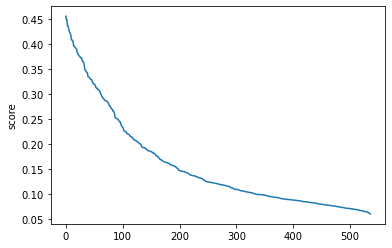

In [21]:
sns.lineplot(data=leads, x=leads.index, y="score")

In [ ]:
leads[leads.feature.str.startswith("Borzoi")]

In [ ]:
leads[leads.feature.str.startswith("CADD")]

In [ ]:
leads[leads.feature.str.startswith("GPN-MSA")]

In [22]:
lead_features = leads.feature.head(100)

In [ ]:
leads.head(10)

In [ ]:
corr = V[lead_features].corr(method="spearman").abs()
corr

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# maybe should just use auprc
ranked_features = V[features].corrwith(V["label"], method="spearman").abs().sort_values(ascending=False)
ranked_features.head(10)

In [ ]:
#corr = V[["label"] + features].corr(method="spearman").abs()
corr = V[["label"] + ranked_features.head(50).index.values.tolist()].corr(method="spearman").abs()
corr

In [ ]:
from scipy.cluster.hierarchy import linkage, leaves_list

# need to do this better, label was clustering much better before

# perform hierarchical clustering
linkage_matrix = linkage(corr, method='average')
# get the reordered index
reordered_index = leaves_list(linkage_matrix)
# reorder the correlation matrix
corr = corr.iloc[reordered_index, reordered_index]
corr

In [ ]:
# TODO: should also show correlation with ref and alt (1-hot first, perhaps)
# only within GPN-MSA
# maybe 1-hot the multiplication of ref and alt (and dedup rc)

# TODO: try largest merged dataset
# TODO: filter to features with high correlation with label

label_idx = corr.columns.tolist().index('label')

idx = slice(None)
#idx = slice(45, 65)
#idx = slice(500, 700)
#idx = slice(label_idx-30, label_idx+30)

plt.figure(figsize=(20, 20))
sns.heatmap(
    corr.iloc[idx, idx],
    square=True,
    vmin=0, vmax=1,
)
#sns.clustermap(
    #corr.iloc[idx, idx],
    #corr,
    #cmap="coolwarm",
    #figsize=(30, 30),
#)
#plt.savefig("correlation.pdf", bbox_inches="tight")

In [5]:
def _eval(V, col, flip=False):
    balanced = V.label.sum() == len(V) // 2
    metric = roc_auc_score if balanced else average_precision_score
    res = []
    for chrom in V.chrom.unique():
        V_chrom = V[V.chrom == chrom]
        res.append(metric(V_chrom.label, V_chrom[col] if not flip else -V_chrom[col]))
    return np.mean(res)


def eval(V, col):
    return max(_eval(V, col, False), _eval(V, col, True))

## Training classifier

In [13]:
res4 = []
for f in tqdm(features):
    res4.append([f, eval(V, f)])
res4 = pd.DataFrame(res4, columns=["feature", "AUPRC"]).sort_values("AUPRC", ascending=False)
res4

100%|█████████████████████████████████████████████████████████| 768/768 [00:09<00:00, 76.83it/s]


,feature,AUPRC
478,GPN-MSA_InnerProducts_embedding_478,0.661756
663,GPN-MSA_InnerProducts_embedding_663,0.654114
223,GPN-MSA_InnerProducts_embedding_223,0.651910
635,GPN-MSA_InnerProducts_embedding_635,0.621730
437,GPN-MSA_InnerProducts_embedding_437,0.607361
...,...,...
311,GPN-MSA_InnerProducts_embedding_311,0.172811
291,GPN-MSA_InnerProducts_embedding_291,0.171856
455,GPN-MSA_InnerProducts_embedding_455,0.171658
748,GPN-MSA_InnerProducts_embedding_748,0.170994


In [14]:
#clf = Pipeline([
#    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
#    ('scaler', RobustScaler()),
#    #('feature_selection', SelectKBest(score_func=f_classif, k=30)),
#    #('feature_selection', SelectFdr(score_func=f_classif, alpha=0.05)),
#    #('feature_selection', SelectFromModel(LogisticRegression(C=1e-1, penalty="l1", random_state=42, solver="saga"))),
#    #('feature_selection', SelectFromModel(RandomForestClassifier(C=1e-1, penalty="l1", random_state=42, solver="saga"))),
#    ('linear', LogisticRegressionCV(
#        class_weight="balanced",
#        scoring="roc_auc" if balanced else "average_precision",
#        #Cs=np.logspace(-10, 10, 41),
#        #cv=3,
#        random_state=42,
#        n_jobs=-1,
#        #penalty="elasticnet", l1_ratios=[0, 0.25, 0.5, 0.75, 1], solver="saga",
#    ))
#    #(
#    #    'random_forest',
#    #    RandomForestClassifier(
#    #        class_weight="balanced",
#    #        n_estimators=1000,
#    #        random_state=42,
#    #        n_jobs=-1,
#    #    )
#    #),
#])

from sklearn.model_selection import GroupKFold, GridSearchCV
from IPython.display import display


def train_predict_best_feature(V_train, V_test, features):
    balanced = V_train.label.sum() == len(V_train) // 2
    metric = roc_auc_score if balanced else average_precision_score
    scores = [
        max(metric(V_train.label, V_train[f]), metric(V_train.label, -V_train[f]))
        for f in features
    ]
    chosen = features[np.argmax(scores)]
    return V_test[chosen].values


def train_predict_logistic_regression(V_train, V_test, features):
    balanced = V_train.label.sum() == len(V_train) // 2
    print(f"{balanced=}")
    pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        #('scaler', RobustScaler()),
        ('scaler', StandardScaler()),
        ('linear', LogisticRegression(
            class_weight="balanced",
            random_state=42,
            #penalty="l1", solver="saga",
            #n_jobs=-1,
        ))
    ])

    # TODO: figure out where to put n_jobs

    param_grid = {
        #'linear__C': np.logspace(-4, 0, 11),
        'linear__C': np.logspace(-10, 0, 6),
        #"linear__l1_ratio": [0, 0.5, 1],
    }

    clf = GridSearchCV(
        pipeline,
        param_grid,
        scoring="roc_auc" if balanced else "average_precision",
        #cv=GroupKFold(n_splits=min(5, V_train.chrom.nunique())),
        cv=GroupKFold(n_splits=min(2, V_train.chrom.nunique())),
        n_jobs=-1,
        #verbose=1,
    )
    
    #Cs=np.logspace(-20, 0, 11),
    #penalty="elasticnet", solver="saga", l1_ratios=[0, 0.5, 1],
    #cv=GroupKFold(n_splits=5),


    clf.fit(V_train[features], V_train.label, groups=V_train.chrom)
    #print(f"{pipeline.named_steps['linear'].C_=}")
    #print(f"{clf.named_steps['linear'].l1_ratio_=}")
    #print(f"{clf.named_steps['linear'].scores_=}")
    print(f"{(clf.best_estimator_.named_steps['linear'].coef_ != 0).sum()=}")
    print(f"{clf.best_params_=}")
    #display(pd.DataFrame(clf.cv_results_).sort_values("rank_test_score").head(5))
    display(pd.DataFrame(clf.cv_results_))
    return clf.predict_proba(V_test[features])[:, 1]

In [15]:
mask_train_list = []
for chrom in V.chrom.unique():
    mask_train = V.chrom != chrom
    mask_train_list.append(mask_train)

for mask_train in tqdm(mask_train_list):
    mask_test = ~mask_train
    V.loc[mask_test, "score"] = train_predict_logistic_regression(
        V[mask_train], V[mask_test], features
    )
    V.loc[mask_test, "score2"] = train_predict_best_feature(
        V[mask_train], V[mask_test], features
    )


  0%|                                                                     | 0/4 [00:00<?, ?it/s]

balanced=False
(clf.best_estimator_.named_steps['linear'].coef_ != 0).sum()=768
clf.best_params_={'linear__C': 9.999999999999999e-11}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linear__C,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032185,0.010291,0.024026,0.015937,0.0,{'linear__C': 9.999999999999999e-11},0.148489,0.625000,0.386744,0.238256,1
1,0.034269,0.005279,0.019015,0.012704,0.0,{'linear__C': 1e-08},0.148489,0.625000,0.386744,0.238256,1
2,0.030372,0.001875,0.015031,0.008026,0.000001,{'linear__C': 1e-06},0.148489,0.625000,0.386744,0.238256,1
3,0.036490,0.015463,0.020895,0.009914,0.0001,{'linear__C': 9.999999999999999e-05},0.147626,0.625000,0.386313,0.238687,4
4,0.022317,0.007771,0.008308,0.002870,0.01,{'linear__C': 0.01},0.157433,0.308824,0.233128,0.075695,5
5,0.029344,0.001704,0.005759,0.000605,1.0,{'linear__C': 1.0},0.175560,0.142157,0.158858,0.016702,6


 25%|███████████████▎                                             | 1/4 [00:01<00:05,  1.96s/it]

balanced=False
(clf.best_estimator_.named_steps['linear'].coef_ != 0).sum()=768
clf.best_params_={'linear__C': 9.999999999999999e-05}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linear__C,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.030927,0.006308,0.011218,0.000090,0.0,{'linear__C': 9.999999999999999e-11},0.154513,0.750000,0.452256,0.297744,2
1,0.028534,0.006634,0.009629,0.000475,0.0,{'linear__C': 1e-08},0.154513,0.750000,0.452256,0.297744,2
2,0.024458,0.002862,0.008881,0.000612,0.000001,{'linear__C': 1e-06},0.154513,0.750000,0.452256,0.297744,2
3,0.045218,0.001109,0.009046,0.003124,0.0001,{'linear__C': 9.999999999999999e-05},0.161655,0.833333,0.497494,0.335839,1
4,0.028153,0.002797,0.009497,0.002031,0.01,{'linear__C': 0.01},0.191167,0.583333,0.387250,0.196083,5
5,0.023698,0.003937,0.005669,0.000331,1.0,{'linear__C': 1.0},0.167631,0.226190,0.196911,0.029280,6


 50%|██████████████████████████████▌                              | 2/4 [00:03<00:03,  1.93s/it]

balanced=False
(clf.best_estimator_.named_steps['linear'].coef_ != 0).sum()=768
clf.best_params_={'linear__C': 9.999999999999999e-05}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linear__C,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022246,0.011313,0.008539,0.002002,0.0,{'linear__C': 9.999999999999999e-11},0.127945,0.211111,0.169528,0.041583,3
1,0.032749,0.002245,0.009950,0.000424,0.0,{'linear__C': 1e-08},0.127945,0.211111,0.169528,0.041583,3
2,0.029082,0.002071,0.009214,0.000744,0.000001,{'linear__C': 1e-06},0.127945,0.211111,0.169528,0.041583,3
3,0.022401,0.008286,0.006693,0.001374,0.0001,{'linear__C': 9.999999999999999e-05},0.125307,0.277778,0.201542,0.076235,1
4,0.026663,0.002926,0.008332,0.003122,0.01,{'linear__C': 0.01},0.113707,0.225490,0.169599,0.055891,2
5,0.022940,0.004486,0.005678,0.000317,1.0,{'linear__C': 1.0},0.111328,0.155556,0.133442,0.022114,6


 75%|█████████████████████████████████████████████▊               | 3/4 [00:05<00:01,  1.95s/it]

balanced=False
(clf.best_estimator_.named_steps['linear'].coef_ != 0).sum()=768
clf.best_params_={'linear__C': 9.999999999999999e-11}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linear__C,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031194,0.000139,0.009017,0.000038,0.0,{'linear__C': 9.999999999999999e-11},0.194444,0.250,0.222222,0.027778,1
1,0.022775,0.010621,0.007238,0.002355,0.0,{'linear__C': 1e-08},0.194444,0.250,0.222222,0.027778,1
2,0.030372,0.001337,0.008936,0.000063,0.000001,{'linear__C': 1e-06},0.194444,0.250,0.222222,0.027778,1
3,0.038692,0.007617,0.009107,0.000222,0.0001,{'linear__C': 9.999999999999999e-05},0.194444,0.250,0.222222,0.027778,1
4,0.018335,0.004958,0.007572,0.002683,0.01,{'linear__C': 0.01},0.173611,0.125,0.149306,0.024306,5
5,0.024117,0.007226,0.005029,0.000184,1.0,{'linear__C': 1.0},0.173611,0.100,0.136806,0.036806,6


100%|█████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.92s/it]


In [16]:
eval(V, "score")

0.2544874192341918

In [17]:
eval(V, "score2")

0.2801543330319871